In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import yfinance as yf
import datetime
from datetime import date
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tools.eval_measures import rmse, meanabs
%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [3]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

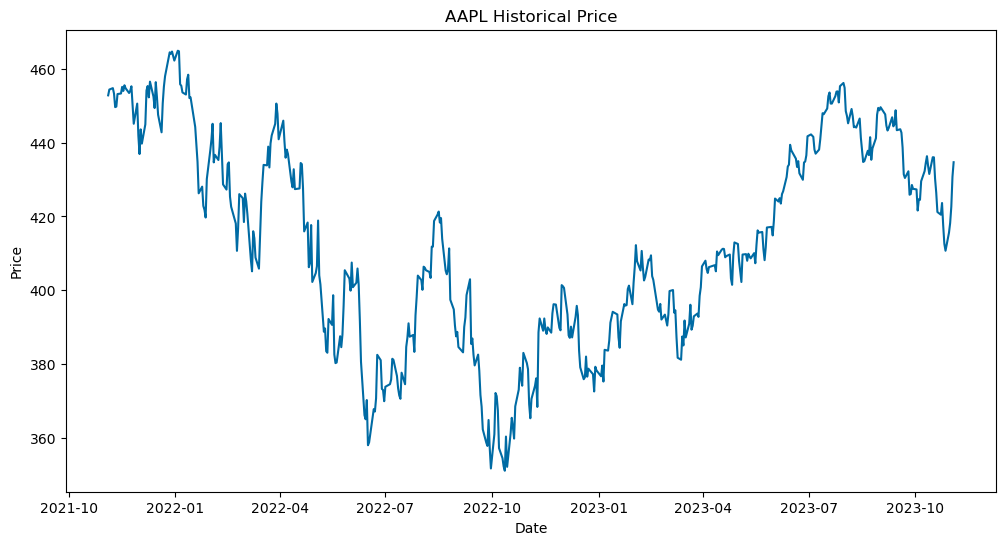

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='24mo')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Historical Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=410.823166, mean2=414.278171, mean_percent_diff=0.840996
variance1=1017.748920, variance2=527.935100, var_percent_diff=-48.127177


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -2.203446
p-value: 0.204997
Critical Values:
{'1%': -3.4434437319767452, '5%': -2.8673146875484368, '10%': -2.569845688481135}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(0.8047068953324722, 0.01, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.80
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rkartawi\AppData\Local\Temp\ipykernel_12800\2395884048.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(X)


##### P-value < .05; therefore, not stationary

### Transform into stationary series

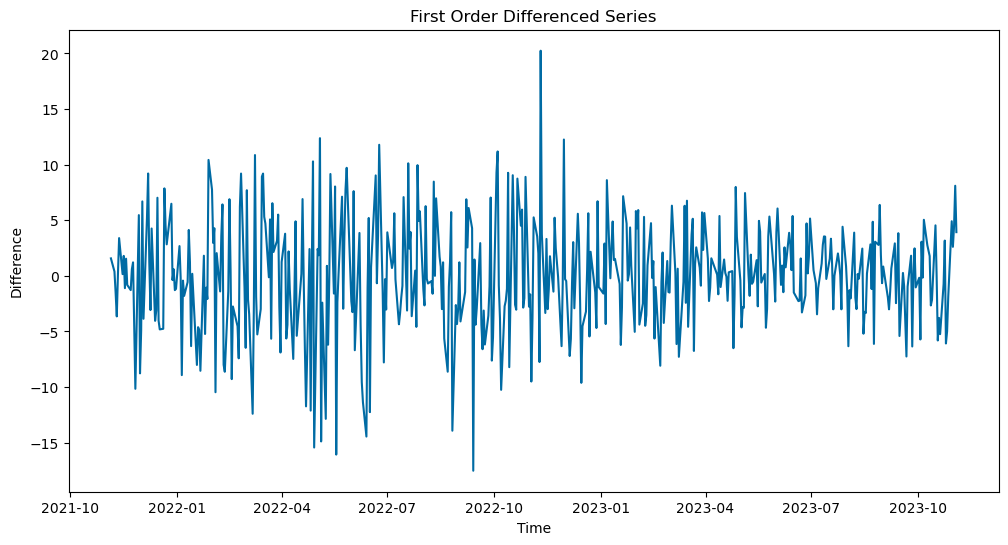

In [8]:
X['Difference'] = X.diff()
plt.figure(figsize=(12,6))
plt.plot(X['Difference'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.show()

In [9]:
result = adfuller(X.Difference.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -21.970225
p-value: 0.000000
Critical Values:
{'1%': -3.443470002903981, '5%': -2.867326248740681, '10%': -2.569851849873108}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
close = aapl.history(period='36mo')['Close']
print(len(close))
close_train = close.iloc[:506]
close_valid = close.iloc[-260:]

755


## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [12]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

Time Series Evaluation Metrics
MSE = 2070.066768231585
MAE = 39.06707686650884
RMSE = 45.49798641952833
MAPE = 0.09169150826429412
r2 = -2.7016810392934625



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


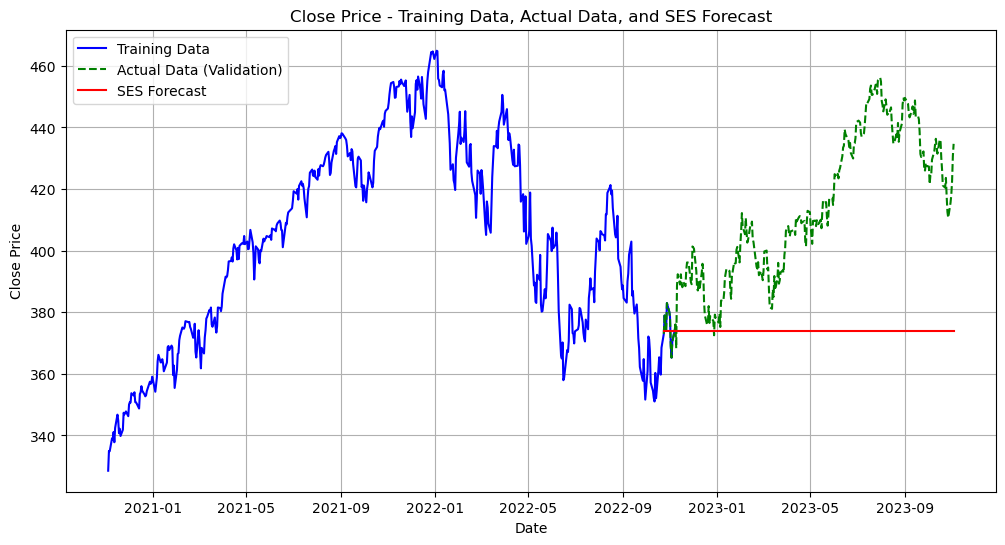

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#### to be investigate ######

# #impute
# close = close.ffill()
# close = close.asfreq('D')

# decomposition = seasonal_decompose(close, model='additive')
# decomposition.plot()
# plt.show()

# trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

# # Plot autocorrelation
# plot_acf(close, lags=30)  # Adjust the number of lags as needed
# plt.show()

#### to be investigate ######


In [15]:
aes_model = ExponentialSmoothing(close_train, trend='add', seasonal='add', seasonal_periods=8, initialization_method='estimated')
aes_model = aes_model.fit(smoothing_level=0.1, smoothing_slope=0.1)

aes_pred = aes_model.forecast(steps=len(close_valid))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

Time Series Evaluation Metrics
MSE = 203.19130565856787
MAE = 10.9603448246139
RMSE = 14.254518780322536
MAPE = 0.02651735649613479
r2 = 0.6366545200142752

None


C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\Temp\ipykernel_12800\1657936991.py:2: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  aes_model = aes_model.fit(smoothing_level=0.1, smoothing_slope=0.1)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an excep

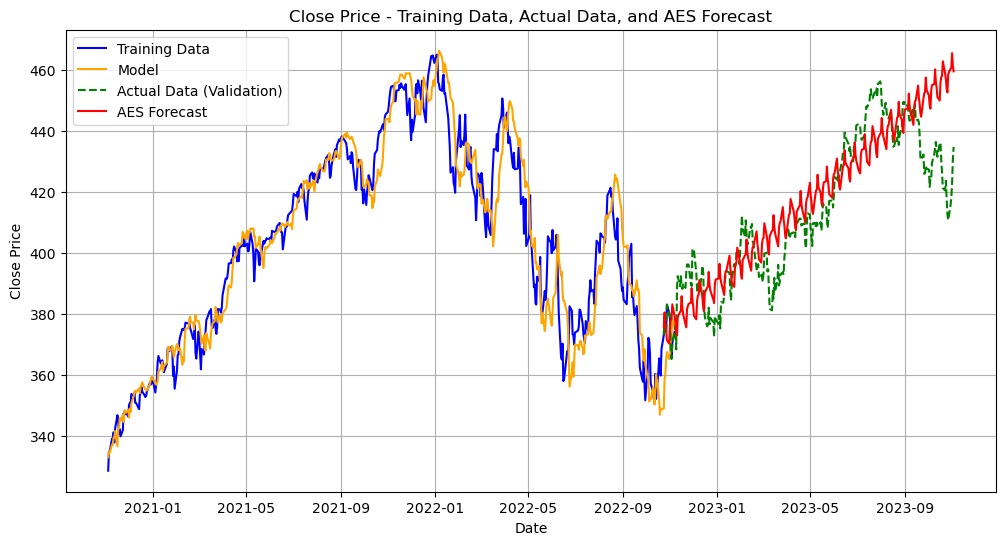

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
aapl.income_stmt

""


In [18]:
aapl.quarterly_income_stmt

""


In [19]:
aapl.balance_sheet

""


In [20]:
aapl.quarterly_cashflow

""


In [21]:
aapl.major_holders

,0,1
0,Previous Close,430.76
1,Open,433.14
2,Bid,435.23 x 900
3,Ask,435.17 x 1300
4,Day's Range,433.01 - 436.29
5,52 Week Range,373.61 - 459.44
6,Volume,100024745
7,Avg. Volume,83158626


In [22]:
aapl.institutional_holders

,0,1
0,Net Assets,393.77B
1,NAV,434.74
2,PE Ratio (TTM),21.90
3,Yield,1.56%
4,YTD Daily Total Return,14.94%
5,Beta (5Y Monthly),1.00
6,Expense Ratio (net),0.09%
7,Inception Date,1993-01-22


In [23]:
aapl.mutualfund_holders

In [24]:
aapl.news

[{'uuid': '5dbbc2a4-ba53-45f1-b617-4119c3765df2',
  'title': 'Stock market news today: Stocks rise as jobs growth cools more than expected',
  'publisher': 'Yahoo Finance',
  'link': 'https://finance.yahoo.com/news/stock-market-news-today-stocks-rise-as-jobs-growth-cools-more-than-expected-133705314.html',
  'providerPublishTime': 1699042040,
  'type': 'STORY',
  'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/XVZMrgaEeqlbgRQ6B9rFAw--~B/aD00MDAwO3c9NjAwMDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2023-11/ec449170-79cc-11ee-97f3-6d9feb44432d',
     'width': 6000,
     'height': 4000,
     'tag': 'original'},
    {'url': 'https://s.yimg.com/uu/api/res/1.2/ZlWVoDQ5PrGH2QI3NsseYw--~B/Zmk9ZmlsbDtoPTE0MDtweW9mZj0wO3c9MTQwO2FwcGlkPXl0YWNoeW9u/https://s.yimg.com/os/creatr-uploaded-images/2023-11/ec449170-79cc-11ee-97f3-6d9feb44432d',
     'width': 140,
     'height': 140,
     'tag': '140x140'}]},
  'relatedTickers': ['^DJI', '^IXIC', 'QQQ', 'S

In [25]:
yf.pdr_override()

y_symbols = ['^GSPC', 'ES=F', 'NQ=F', 'YM=F', '^RUT', '^DJT', '^GDAXI', '^N225', '^SSMI', '^STOXX50E', '^FCHI', '^GSPTSE', '^HSI', '000001.SS', '^KS11', '^NSEI', '^AXJO']
stocks = ['^SPX']

In [26]:
startdate = datetime.datetime(2020,3,16)
today = date.today()
enddate = today

In [27]:
indices = web.get_data_yahoo(y_symbols, start=startdate, end=enddate)
stocks = web.get_data_yahoo(stocks, start=startdate, end=enddate)

[*********************100%%**********************]  17 of 17 completed
[*********************100%%**********************]  1 of 1 completed


In [28]:
stocks

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7805450000
2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8370250000
2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8799300000
2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7956100000
2020-03-20,2431.939941,2453.010010,2295.560059,2304.919922,2304.919922,9053950000
...,...,...,...,...,...,...
2023-10-30,4139.390137,4177.470215,4132.939941,4166.819824,4166.819824,3911140000
2023-10-31,4171.330078,4195.549805,4153.120117,4193.799805,4193.799805,4249470000
2023-11-01,4201.270020,4245.640137,4197.740234,4237.859863,4237.859863,4224900000


In [29]:
aapl.history(period='1mo')

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-10-04 00:00:00-04:00,422.070007,425.429993,420.559998,424.660004,87453000,0.0,0.0,0.0
2023-10-05 00:00:00-04:00,424.359985,425.369995,421.170013,424.500000,70142700,0.0,0.0,0.0
2023-10-06 00:00:00-04:00,421.970001,431.130005,420.600006,429.540009,113202700,0.0,0.0,0.0
2023-10-09 00:00:00-04:00,427.579987,432.880005,427.010010,432.290009,80374400,0.0,0.0,0.0
2023-10-10 00:00:00-04:00,432.940002,437.220001,432.529999,434.540009,78607300,0.0,0.0,0.0
2023-10-11 00:00:00-04:00,435.640015,436.579987,433.179993,436.320007,62451700,0.0,0.0,0.0
2023-10-12 00:00:00-04:00,436.950012,437.339996,431.230011,433.660004,81154200,0.0,0.0,0.0
2023-10-13 00:00:00-04:00,435.209991,436.450012,429.880005,431.500000,95143100,0.0,0.0,0.0
2023-10-16 00:00:00-04:00,433.820007,437.140015,433.570007,436.040009,75433200,0.0,0.0,0.0


In [30]:
aapl.get_shares_full(start="2022-01-01", end=None)

In [31]:
opt_df = aapl.option_chain('2023-11-10')
call = opt_df.calls
put = opt_df.puts
put

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY231110P00300000,2023-11-02 13:50:08+00:00,300.0,0.01,0.00,0.01,0.00,0.0,2.0,3574.0,0.812502,False,REGULAR,USD
1,SPY231110P00305000,2023-11-02 13:30:04+00:00,305.0,0.01,0.00,0.01,0.00,0.0,40.0,1060.0,0.781252,False,REGULAR,USD
2,SPY231110P00310000,2023-11-03 20:01:59+00:00,310.0,0.01,0.00,0.01,-0.01,-50.0,522.0,478.0,0.750003,False,REGULAR,USD
3,SPY231110P00315000,2023-11-03 19:53:02+00:00,315.0,0.01,0.01,0.02,0.00,0.0,306.0,1507.0,0.773440,False,REGULAR,USD
4,SPY231110P00320000,2023-11-02 13:31:35+00:00,320.0,0.01,0.01,0.02,0.00,0.0,2.0,315.0,0.742190,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,SPY231110P00480000,2023-10-06 19:45:00+00:00,480.0,49.53,44.76,45.00,0.00,0.0,1.0,0.0,0.000010,True,REGULAR,USD
117,SPY231110P00500000,2023-11-01 13:35:11+00:00,500.0,81.18,64.76,64.99,0.00,0.0,4.0,0.0,0.000010,True,REGULAR,USD
118,SPY231110P00505000,2023-10-20 19:49:15+00:00,505.0,83.05,69.76,69.99,0.00,0.0,1.0,0.0,0.000010,True,REGULAR,USD
119,SPY231110P00510000,2023-10-18 18:48:16+00:00,510.0,78.19,74.76,74.99,0.00,0.0,NaN,0.0,0.000010,True,REGULAR,USD


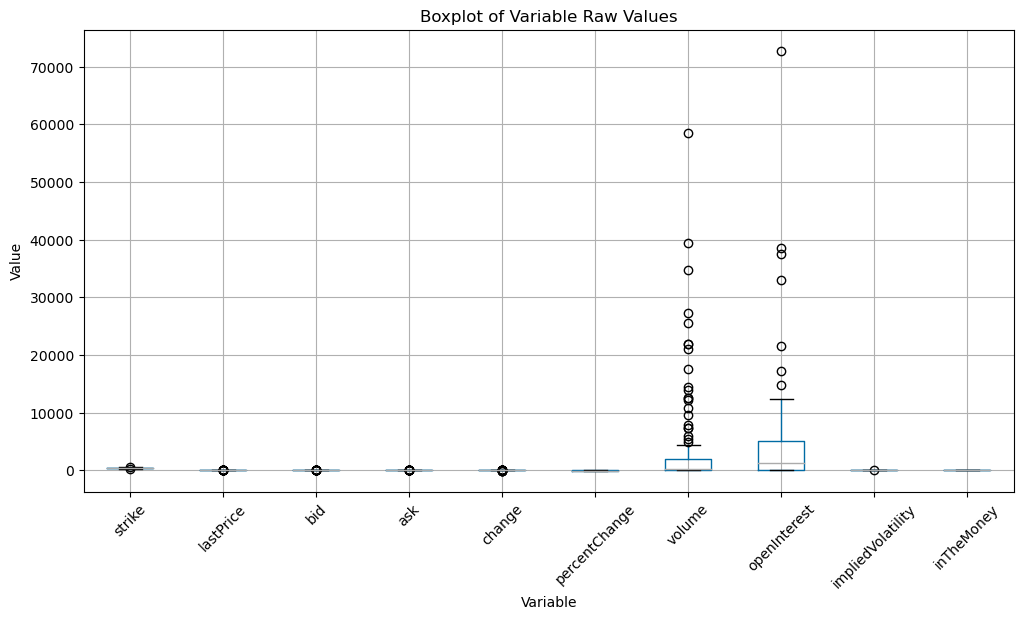

In [32]:
ax = put.boxplot(return_type='axes', rot=45, figsize=(12, 6))
ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Boxplot of Variable Raw Values")
plt.show()

In [33]:
put.describe()

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,118.000000,120.000000,121.000000
mean,410.260331,8.522727,7.015207,7.077190,-1.261074,-31.131283,3720.779661,4292.583333,0.238981
std,43.325902,18.661969,15.943904,16.015029,3.459900,25.772847,8819.925750,9097.488222,0.211239
min,300.000000,0.010000,0.000000,0.010000,-24.980000,-79.351970,1.000000,0.000000,0.000010
25%,384.000000,0.060000,0.040000,0.050000,-0.710000,-52.941177,9.250000,7.750000,0.079721
50%,413.000000,0.140000,0.120000,0.130000,-0.030000,-33.333336,192.500000,1280.000000,0.195321
75%,439.000000,4.800000,4.740000,4.800000,0.000000,0.000000,1914.250000,5084.500000,0.367194
max,530.000000,94.790000,94.750000,94.990000,0.010000,33.333336,58529.000000,72751.000000,0.812502


In [34]:
df_temp

NameError: name 'df_temp' is not defined

In [ ]:
aapl.options